# In the first part of the code i will load the DPU library and the model.

We are loading the model through the DpuOverlay library

In [1]:
from pynq.lib.video import *
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_face_binary_classifier_0.elf")

# Load libraries

In [2]:
from time import time
import numpy as np
from dnndk import n2cube
import matplotlib.pyplot as plt

# Setting the input and output layers.

In [3]:
KERNEL_NAME = "face_binary_classifier_0"
KERNEL_CONV_INPUT = "conv2d_1_convolution"
KERNEL_FC_OUTPUT = "output_logits_MatMul"

In [4]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_NAME)
task = n2cube.dpuCreateTask(kernel, 0)

In [5]:
input_len = n2cube.dpuGetInputTensorSize(task, KERNEL_CONV_INPUT)
size = n2cube.dpuGetOutputTensorSize(task, KERNEL_FC_OUTPUT)
channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_FC_OUTPUT)
outputScale = n2cube.dpuGetOutputTensorScale(task, KERNEL_FC_OUTPUT)

# Setting the camera as HW input.

In [6]:
# initialize camera from OpenCV
import cv2

videoIn = cv2.VideoCapture(0)
    
while(str(videoIn.isOpened())=="False"):
    videoIn = cv2.VideoCapture(0)
print("Capture device is open")

Capture device is open


# Testing the input image

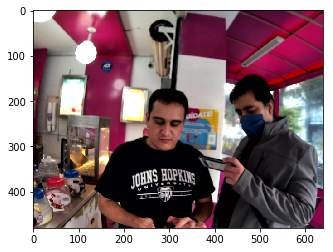

In [7]:
# Capture webcam image
import numpy as np

ret, frame = videoIn.read()
# Output webcam image as JPEG
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(frame[:,:,[2,1,0]])
plt.show()


# Testing the model, this code is in an infinite loop to stop it please stop the kernel.

In [8]:
%matplotlib inline
import time
import pylab as plt
from IPython import display
from matplotlib import pyplot as plt
import paho.mqtt.client as mqtt
import base64
import json
import threading
from bluepy.btle import UUID, Peripheral
import struct

face_cascade = cv2.CascadeClassifier(
        '/home/xilinx/jupyter_notebooks/base/video/data/'
        'haarcascade_frontalface_default.xml')

# Define event callbacks
def on_connect(client, userdata, flags, rc):
    print("rc: " + str(rc))

def on_message(client, obj, msg):
    print(msg.topic + " " + str(msg.qos) + " " + str(msg.payload))

def on_publish(client, obj, mid):
    print("mid: " + str(mid))

def on_subscribe(client, obj, mid, granted_qos):
    print("Subscribed: " + str(mid) + " " + str(granted_qos))

def on_log(client, obj, level, string):
    print(string)

mqttc = mqtt.Client()
# Assign event callbacks

frame = ""
p = ""
marker = 0
counter = 0
flag=1
startWait = 0

def Wait_Service():
    global flag
    global startWait
    while 1:
        if(startWait):
            print("Start Wait")
            time.sleep(30)
            flag = 1
            startWait = 0
            print("Stop Wait")

def MQTT_Service():
    global mqttc
    mqttc.on_message = on_message
    mqttc.on_connect = on_connect
    mqttc.on_publish = on_publish
    mqttc.on_subscribe = on_subscribe
    mqttc.connect('192.168.43.1', 1883)
    print("MQTT: ok")
    mqttc.loop_forever()
    
def BLE():
    global p
    while 1:
        try:
            p = Peripheral('30:ae:a4:28:c2:02')
            print("BT:ok")
            break
        except:
            print("BT:error 1")
    
def BLE_Send(select):
    global p
    global flag
    global startWait
    if(select==1):
        try:
            characteristics = p.getCharacteristics()
            for k in characteristics:
                if k.uuid == "7325577d-a662-4789-bc62-24dfb14e5759":
                    temp = k.read().decode()
                    print("Message:"+str(temp))
                    k.write(struct.pack('<B', 0x31))
                    flag = 0
                    startWait=1
                    
        except:
            print("BT: error")
            BLE()
    else:
        try:
            characteristics = p.getCharacteristics()
            for k in characteristics:
                if k.uuid == "7325577d-a662-4789-bc62-24dfb14e5759":
                    temp = k.read().decode()
                    print("Message:"+str(temp))
                    k.write(struct.pack('<B', 0x30))
                    flag = 0
                    startWait=1
                    
        except:
            print("BT: error")
            BLE()
    
    
def MQTT_Send(image):
    global mqttc
    img = image
    width = int(img.shape[1])
    height = int(img.shape[0])
    img = img[0: height, round(width*.30):round(width*.70)]
    scale_percent = 100 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized, buffer = cv2.imencode('.jpg', resized)
    jpg_as_text = base64.b64encode(buffer)
    jsons = {"img":jpg_as_text.decode(),"state":1}
    mqttc.publish("/device1", json.dumps(jsons))
    time.sleep(1)
    

def my_service():
    global mqttc
    global frame
    global marker
    global counter
    global waitservice
    global flag
    global startWait
    BLE()
    while 1:
        ret, frame = videoIn.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            start_time = time.time()
            raw_data = []
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (64,64), interpolation = cv2.INTER_AREA)
            roi_gray = roi_gray/255.0
            raw_data.append(roi_gray)
            raw_data = np.array(raw_data, dtype="float32")
            raw_data = np.expand_dims(raw_data, axis=3)
            n2cube.dpuSetInputTensorInHWCFP32(task, KERNEL_CONV_INPUT, 
                                              raw_data[0,:,:,0], input_len)
            n2cube.dpuRunTask(task)
            softmax = n2cube.dpuRunSoftmax(conf, channel, size//channel, outputScale)
            prediction = softmax.argmax()
            print("FPS: ", 1.0 / (time.time() - start_time))
            if(prediction):
                frame = cv2.putText(frame, str("Facemask :)"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
                if(marker ==2 and flag):
                    counter = 0
                elif(flag):
                    marker = 1
            else:
                frame = cv2.putText(frame, str("Facemask X"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
                if(marker == 1 and flag):
                    counter = 0
                elif(flag):
                    marker = 2
        try:
            MQTT_Send(frame)
        except:
            print("error")
        
        if(marker==1 and flag):
            counter=counter + 1
            if(counter > 3 and flag):
                BLE_Send(1)
                print("BLE SEND Face")
                counter=0
                
        elif(marker==2 and flag):
            counter=counter + 1
            if(counter > 3 and flag):
                BLE_Send(0)
                print("BLE Nope")
                counter=0
        
w = threading.Thread(target=my_service)
mqttservice = threading.Thread(target=MQTT_Service)  # use default name
waitservice = threading.Thread(target=Wait_Service)

waitservice.start()
mqttservice.start()
w.start()

MQTT: ok
BT:ok
rc: 0
FPS:  18.193626185818328
mid: 1
FPS:  26.50814336364843
mid: 2
FPS:  26.486214779171245
mid: 3
FPS:  26.491400708659924
mid: 4
BT: error
BT:ok
BLE Nope
FPS:  26.370480280158187
mid: 5
FPS:  26.53329706408902
mid: 6
FPS:  26.65419420437214
mid: 7
FPS:  26.515013970895023
mid: 8
Message:Hello From Dispenser 1
BLE Nope
Start Wait
mid: 9
mid: 10
mid: 11
mid: 12
mid: 13
mid: 14
mid: 15
mid: 16
mid: 17
mid: 18
mid: 19
mid: 20
